In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.models as models

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据集准备
class AnimalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.animals = ['cow', 'sheep', 'deer', 'horse']
        self.images = []
        self.labels = []

        for i, animal in enumerate(self.animals):
            animal_dir = os.path.join(root_dir, animal)
            for image_name in os.listdir(animal_dir):
                self.images.append(os.path.join(animal_dir, image_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 数据增强和标准化
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_dataset = AnimalDataset(root_dir='training_data', transform=transform)
test_dataset = AnimalDataset(root_dir='testing_data', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义模型并移动到设备
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

# 冻结模型的所有层
for param in model.parameters():
    param.requires_grad = False

# 只训练最后的全连接层
for param in model.fc.parameters():
    param.requires_grad = True

# 训练模型
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

best_val_loss = float('inf')
total_epochs = 50  # 定义总的训练周期
for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 验证模型
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    
    # 更新学习率
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}/{total_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 测试模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 0.7233, Validation Loss: 0.3965


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50, Training Loss: 0.3378, Validation Loss: 0.2471


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50, Training Loss: 0.2801, Validation Loss: 0.2554


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50, Training Loss: 0.2754, Validation Loss: 0.2059


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50, Training Loss: 0.2132, Validation Loss: 0.1778


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50, Training Loss: 0.2148, Validation Loss: 0.2055


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50, Training Loss: 0.1875, Validation Loss: 0.1769


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50, Training Loss: 0.1733, Validation Loss: 0.1982


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50, Training Loss: 0.2051, Validation Loss: 0.1469


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50, Training Loss: 0.1652, Validation Loss: 0.1898


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50, Training Loss: 0.1610, Validation Loss: 0.1575


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/50, Training Loss: 0.1657, Validation Loss: 0.1642


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/50, Training Loss: 0.1544, Validation Loss: 0.1440


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/50, Training Loss: 0.1791, Validation Loss: 0.2109


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/50, Training Loss: 0.1680, Validation Loss: 0.1565


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/50, Training Loss: 0.1428, Validation Loss: 0.1602


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/50, Training Loss: 0.1636, Validation Loss: 0.1375


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/50, Training Loss: 0.1438, Validation Loss: 0.1402


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/50, Training Loss: 0.1570, Validation Loss: 0.1454


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Training Loss: 0.1648, Validation Loss: 0.1289


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/50, Training Loss: 0.1413, Validation Loss: 0.1599


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/50, Training Loss: 0.1415, Validation Loss: 0.1382


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/50, Training Loss: 0.1257, Validation Loss: 0.1171


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/50, Training Loss: 0.1426, Validation Loss: 0.1394


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/50, Training Loss: 0.1251, Validation Loss: 0.1235


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/50, Training Loss: 0.1355, Validation Loss: 0.1265


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/50, Training Loss: 0.0992, Validation Loss: 0.1484


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/50, Training Loss: 0.1263, Validation Loss: 0.1476


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/50, Training Loss: 0.1401, Validation Loss: 0.1423


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/50, Training Loss: 0.1144, Validation Loss: 0.1323


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/50, Training Loss: 0.0983, Validation Loss: 0.1500


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/50, Training Loss: 0.1138, Validation Loss: 0.1607


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/50, Training Loss: 0.1168, Validation Loss: 0.1377


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/50, Training Loss: 0.0991, Validation Loss: 0.1292


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/50, Training Loss: 0.1119, Validation Loss: 0.1390


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/50, Training Loss: 0.1067, Validation Loss: 0.1374


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/50, Training Loss: 0.1080, Validation Loss: 0.1367


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/50, Training Loss: 0.1189, Validation Loss: 0.1151


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/50, Training Loss: 0.1028, Validation Loss: 0.1196


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/50, Training Loss: 0.1058, Validation Loss: 0.1288


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/50, Training Loss: 0.1171, Validation Loss: 0.1582


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/50, Training Loss: 0.1181, Validation Loss: 0.1378


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/50, Training Loss: 0.0968, Validation Loss: 0.1345


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/50, Training Loss: 0.1303, Validation Loss: 0.1358


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/50, Training Loss: 0.1013, Validation Loss: 0.1247


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/50, Training Loss: 0.1054, Validation Loss: 0.1204


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/50, Training Loss: 0.1093, Validation Loss: 0.1512


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/50, Training Loss: 0.1110, Validation Loss: 0.1369


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/50, Training Loss: 0.1136, Validation Loss: 0.1351


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50, Training Loss: 0.1096, Validation Loss: 0.1339


/tmp/ipykernel_594/3658727643.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy of the model on the test images: 94.58987783595113%


In [6]:
# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载训练好的模型权重
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 
model = model.to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 定义图片预处理步骤
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 定义图片路径
_img_path = "testing_data/deer/deer_10159.jpg" 

# 加载并预处理图片
img = Image.open(_img_path).convert('RGB')
img_transform = transform(img).unsqueeze(0).to(device) 

# 使用模型进行预测
output = model(img_transform)
_, predicted = torch.max(output.data, 1)

# 定义类别字典
class_dict = {0: 'cow', 1: 'sheep', 2: 'deer', 3: 'horse'}

# 获取预测结果
pred = class_dict[predicted.item()]
print(f'The predicted class for the image is: {pred}')

/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The predicted class for the image is: deer


/tmp/ipykernel_594/2321808170.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


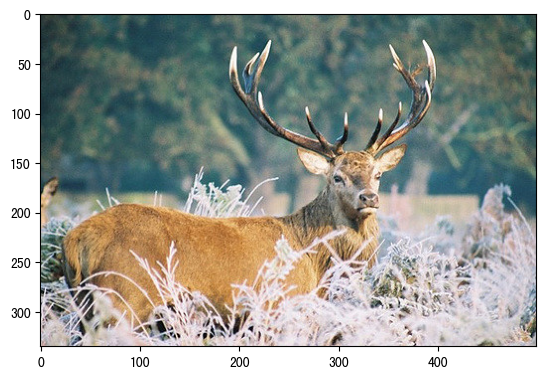

In [7]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

In [8]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.models as models

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据集准备
class AnimalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.animals = ['cow', 'sheep', 'deer', 'horse']
        self.images = []
        self.labels = []

        for i, animal in enumerate(self.animals):
            animal_dir = os.path.join(root_dir, animal)
            for image_name in os.listdir(animal_dir):
                self.images.append(os.path.join(animal_dir, image_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 数据增强和标准化
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_dataset = AnimalDataset(root_dir='training_data', transform=transform)
test_dataset = AnimalDataset(root_dir='testing_data', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义VGG模型
class VGGModel(nn.Module):
    def __init__(self):
        super(VGGModel, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 实例化模型并移动到设备
model = VGGModel().to(device)

# 冻结模型的所有层
for param in model.parameters():
    param.requires_grad = False

# 只训练最后的全连接层
for param in model.classifier.parameters():
    param.requires_grad = True

# 训练模型
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

best_val_loss = float('inf')
total_epochs = 50
for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 验证模型
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}/{total_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_vgg.pth')

# 加载最佳模型
model.load_state_dict(torch.load('best_model_vgg.pth'))

# 测试模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /output/.torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:14<00:00, 37.1MB/s] 


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 2.2185, Validation Loss: 0.2462


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50, Training Loss: 0.3938, Validation Loss: 0.2507


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50, Training Loss: 0.2848, Validation Loss: 0.2377


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50, Training Loss: 0.2407, Validation Loss: 0.2485


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50, Training Loss: 0.2693, Validation Loss: 0.2815


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50, Training Loss: 0.3540, Validation Loss: 0.4418


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50, Training Loss: 0.3157, Validation Loss: 0.3058


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50, Training Loss: 0.2835, Validation Loss: 0.3445


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50, Training Loss: 0.2843, Validation Loss: 0.2744


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50, Training Loss: 0.1575, Validation Loss: 0.2910


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50, Training Loss: 0.1461, Validation Loss: 0.1954


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/50, Training Loss: 0.1185, Validation Loss: 0.2542


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/50, Training Loss: 0.0718, Validation Loss: 0.2658


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/50, Training Loss: 0.0813, Validation Loss: 0.2076


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/50, Training Loss: 0.0854, Validation Loss: 0.2379


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/50, Training Loss: 0.0755, Validation Loss: 0.2010


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/50, Training Loss: 0.0699, Validation Loss: 0.2293


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/50, Training Loss: 0.0569, Validation Loss: 0.2138


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/50, Training Loss: 0.0689, Validation Loss: 0.2132


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Training Loss: 0.0439, Validation Loss: 0.2959


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/50, Training Loss: 0.0795, Validation Loss: 0.2069


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/50, Training Loss: 0.0607, Validation Loss: 0.2415


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/50, Training Loss: 0.0490, Validation Loss: 0.2252


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/50, Training Loss: 0.0442, Validation Loss: 0.2045


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/50, Training Loss: 0.0515, Validation Loss: 0.2343


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/50, Training Loss: 0.0807, Validation Loss: 0.2528


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/50, Training Loss: 0.0499, Validation Loss: 0.2510


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/50, Training Loss: 0.0524, Validation Loss: 0.2530


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/50, Training Loss: 0.0438, Validation Loss: 0.2411


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/50, Training Loss: 0.0543, Validation Loss: 0.2470


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/50, Training Loss: 0.0615, Validation Loss: 0.2237


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/50, Training Loss: 0.0474, Validation Loss: 0.1978


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/50, Training Loss: 0.0572, Validation Loss: 0.2238


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/50, Training Loss: 0.0562, Validation Loss: 0.2064


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/50, Training Loss: 0.0500, Validation Loss: 0.2184


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/50, Training Loss: 0.0654, Validation Loss: 0.1947


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/50, Training Loss: 0.0711, Validation Loss: 0.2317


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/50, Training Loss: 0.0629, Validation Loss: 0.2169


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/50, Training Loss: 0.0616, Validation Loss: 0.2516


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/50, Training Loss: 0.0738, Validation Loss: 0.2299


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/50, Training Loss: 0.0581, Validation Loss: 0.1895


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/50, Training Loss: 0.0589, Validation Loss: 0.2461


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/50, Training Loss: 0.0684, Validation Loss: 0.2223


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/50, Training Loss: 0.0462, Validation Loss: 0.2366


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/50, Training Loss: 0.0501, Validation Loss: 0.1942


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/50, Training Loss: 0.0691, Validation Loss: 0.2253


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/50, Training Loss: 0.0628, Validation Loss: 0.2366


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/50, Training Loss: 0.0560, Validation Loss: 0.2787


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/50, Training Loss: 0.0498, Validation Loss: 0.2623


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50, Training Loss: 0.0467, Validation Loss: 0.1954


/tmp/ipykernel_594/774540593.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_vgg.pth'))


Accuracy of the model on the test images: 92.84467713787086%


In [10]:
# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载训练好的模型权重
model = models.vgg16(pretrained=False) 
model.classifier[6] = nn.Linear(4096, 4) 
model = model.to(device)
model.load_state_dict(torch.load('best_model_vgg.pth'))
model.eval()

# 定义图片预处理步骤
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 定义图片路径
_img_path = "testing_data/sheep/sheep_10231.jpg"  

# 加载并预处理图片
img = Image.open(_img_path).convert('RGB')
img_transform = transform(img).unsqueeze(0).to(device) 

# 使用模型进行预测
output = model(img_transform)
_, predicted = torch.max(output.data, 1)

# 定义类别字典
class_dict = {0: 'cow', 1: 'sheep', 2: 'deer', 3: 'horse'}

# 获取预测结果
pred = class_dict[predicted.item()]
print(f'The predicted class for the image is: {pred}')

/tmp/ipykernel_594/359918401.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_vgg.pth'))


The predicted class for the image is: sheep


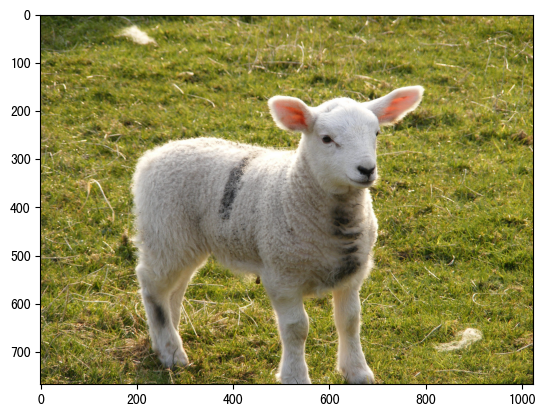

In [11]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()